In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
np.set_printoptions(precision=5)
import matplotlib.pyplot as plt
import copy as cp
import sys, json, pickle
PROJECT_PATHS = ['/home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/', '/Users/noambuckman/mpc-multiple-vehicles/']
for p in PROJECT_PATHS:
    sys.path.append(p)
import src.traffic_world as tw
import src.multiagent_mpc as mpc
import src.car_plotting_multiple as cmplot
import src.solver_helper as helper
import src.vehicle as vehicle
import tqdm

In [2]:
log_directory = "/home/nbuckman/mpc_results/0g5b-c3h6-20200924-145931/"
with open(log_directory + "params.json",'rb') as fp:
    params = json.load(fp)
for k in params:
    print(k,": ", params[k])

load_log_dir :  None
mpc_start_iteration :  0
save_solver_input :  False
T :  5
dt :  0.2
p_exec :  0.4
car_density :  3000
plot_flag :  False
print_flag :  False
n_other :  15
n_mpc :  300
n_ibr :  10
n_processors :  15
n_lanes :  2
k_max_slack :  0.01
k_solve_amb_max_ibr :  10
k_max_solve_number :  3
k_max_round_with_slack :  inf
k_slack_d :  1000
k_CA_d :  100
k_CA_power :  4
wall_CA :  False
default_n_warm_starts :  10
plan_fake_ambulance :  False
default_positions :  False
save_ibr :  1
print_level :  0
pid :  443831
start_time_string :  20200924-145931
save_flag :  True
N :  25
number_ctrl_pts_executed :  10
svo_theta :  1.0471975511965976


In [3]:
def load_ibr_results(i_mpc, i_ibr, log_directory, params, executed=True):
    file_name = log_directory + "data/"+'ibr_m%03di%03d'%(i_mpc, i_ibr)
    n_other = params["n_other"]
    xamb_ibr, uamb_ibr, xamb_des_ibr, all_other_x_ibr, all_other_u_ibr, all_other_x_des_ibr = mpc.load_state(file_name, n_other)
    if executed:
        n_exec = params["number_ctrl_pts_executed"]
        uamb_ibr = uamb_ibr[:, :n_exec]
        xamb_ibr = xamb_ibr[:, :n_exec+1]
        xamb_des_ibr = xamb_des_ibr[:, :n_exec+1]
        for j in range(len(all_other_x_ibr)):
            all_other_u_ibr[j] = all_other_u_ibr[j][:, :n_exec]
            all_other_x_ibr[j] = all_other_x_ibr[j][:, :n_exec+1]
            all_other_x_des_ibr[j] = all_other_x_des_ibr[j][:, :n_exec+1]
    return xamb_ibr, uamb_ibr, xamb_des_ibr, all_other_x_ibr, all_other_u_ibr, all_other_x_des_ibr

In [4]:
xamb_ibr, uamb_ibr, xamb_des_ibr, all_other_x_ibr, all_other_u_ibr, all_other_x_des_ibr = load_ibr_results(0, 0, log_directory, params)

In [7]:
xamb_ibr.shape

(6, 11)

### Compute the Norm Difference

In [8]:
def u_tensor(rounds_mpc, log_directory, params, executed=True):
    '''Generate a tensor whose size is [2, N, mpc, ibr] for a given agent
    executed: True: Only return control inputs that are executed
              False:  Return all control inputs generated during IBR
    '''
    if executed:
        N = params["number_ctrl_pts_executed"]
    else:
        N = params["N"]
        
    U = np.zeros(shape=(2, N, rounds_mpc, params["n_ibr"]))
    Uother = np.zeros(shape=(2, N, rounds_mpc, params["n_ibr"], params["n_other"]))
    for i_mpc in tqdm.trange(rounds_mpc):
        for i_ibr in range(params["n_ibr"]):
            xamb_ibr, uamb_ibr, xamb_des_ibr, all_other_x_ibr, all_other_u_ibr, all_other_x_des_ibr = load_ibr_results(i_mpc, i_ibr, log_directory, params, executed)
            U[:, :, i_mpc, i_ibr] = uamb_ibr
            for j in range(params["n_other"]):
                Uother[:, :, i_mpc, i_ibr, j] = all_other_u_ibr[j]
    return U, Uother

In [12]:
def x_tensor(rounds_mpc, log_directory, params, executed=True):
    '''Generate a tensor whose size is [2, N, mpc, ibr] for a given agent
    executed: True: Only return control inputs that are executed
              False:  Return all control inputs generated during IBR
    '''
    if executed:
        N = params["number_ctrl_pts_executed"]
    else:
        N = params["N"]
        
    X = np.zeros(shape=(2, N+1, rounds_mpc, params["n_ibr"]))
    Xother = np.zeros(shape=(2, N+1, rounds_mpc, params["n_ibr"], params["n_other"]))
    for i_mpc in tqdm.trange(rounds_mpc):
        for i_ibr in range(params["n_ibr"]):
            xamb_ibr, uamb_ibr, xamb_des_ibr, all_other_x_ibr, all_other_u_ibr, all_other_x_des_ibr = load_ibr_results(i_mpc, i_ibr, log_directory, params, executed)
            X[:, :, i_mpc, i_ibr] = xamb_ibr[:2,:]
            for j in range(params["n_other"]):
                Xother[:, :, i_mpc, i_ibr, j] = all_other_x_ibr[j][:2,:]
    return X, Xother

In [57]:
rounds_mpc = 50
X, Xother = x_tensor(rounds_mpc, log_directory, params)

100%|██████████| 50/50 [00:18<00:00,  2.76it/s]


In [66]:
X.shape, Xother.shape

((2, 11, 50, 10), (2, 11, 50, 10, 15))

In [67]:
Xn = np.repeat(X[:,:,:,:,np.newaxis], Xother.shape[-1], 4)
deltaX = Xother - Xn
deltaX0 = deltaX[:, 0, :, -1, :]
sqdist = (deltaX0**2).sum(axis=0)
np.argsort(sqdist[25,:])



array([ 3,  2,  4,  5,  1,  6,  0,  7,  8,  9, 10, 11, 12, 13, 14])

In [68]:
sqdist.shape

(50, 15)

In [69]:
sqdist[25, :]

array([11026.49318,  8578.74828,  4533.41574,  1995.20452,  5502.04332,
        7438.28907, 10015.82911, 13666.95958, 16201.05114, 20245.20561,
       23650.21947, 27383.96696, 32003.50841, 36118.55988, 45297.85332])

## Defining Convergence Metric

$\delta(ibr) = \vec{u}_{mpc, ibr + 1} - \vec{u}_{mpc, ibr}$
which has dimensions
$ [2 x N] $


Let's first take a look at $\delta(ibr)[0]$ which is the convergence at the first control point

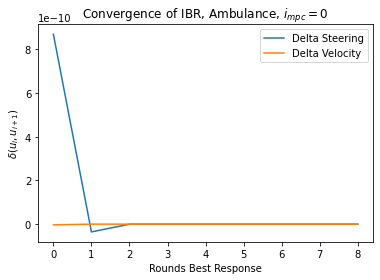

In [70]:
delta_0 = np.diff(U[:,0, 0,:], axis=1)
plt.plot(delta_0[0, :], label="Delta Steering")
plt.plot(delta_0[1, :], label="Delta Velocity")
plt.xlabel("Rounds Best Response")
plt.ylabel('$\delta(u_i, u_{i+1})$')
plt.legend()
plt.title('Convergence of IBR, Ambulance, $i_{mpc}=0$')
plt.show()

#### Plot all agents together but seperate the control axis

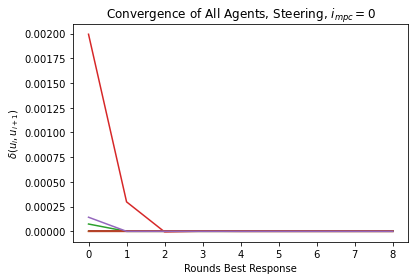

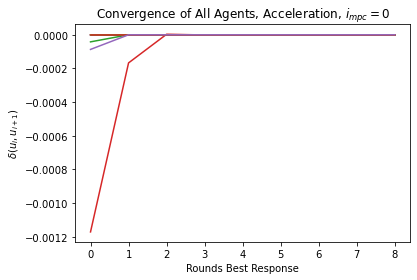

In [71]:
for j in range(params['n_other']):
    delta_0 = np.diff(Uother[:, 0, 0,:, j], axis=1)
    plt.plot(delta_0[0, :])
plt.xlabel("Rounds Best Response")
plt.ylabel('$\delta(u_i, u_{i+1})$')
plt.title('Convergence of All Agents, Steering, $i_{mpc}=0$')
plt.show()

for j in range(params['n_other']):
    delta_0 = np.diff(Uother[:, 1, 0,:,j], axis=1)
    plt.plot(delta_0[0, :])
plt.xlabel("Rounds Best Response")
plt.ylabel('$\delta(u_i, u_{i+1})$')
plt.title('Convergence of All Agents, Acceleration, $i_{mpc}=0$')
plt.show()

### Let's Create a Convergence Metric for a control sequence of $N$ pts, we still split by control axis

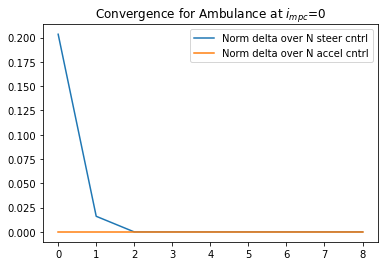

In [74]:
i_mpc = 0
delta_U_mpc = np.diff(U[:, :, i_mpc, :], axis=2)
delta0_norm = np.linalg.norm(delta_U_mpc[0,:,:], axis=0)
delta1_norm = np.linalg.norm(delta_U_mpc[1,:,:], axis=0)
plt.plot(delta0_norm[:], label="Norm delta over N steer cntrl")
plt.plot(delta1_norm[:], label="Norm delta over N accel cntrl")
plt.title("Convergence for Ambulance at $i_{mpc}$=0")
plt.legend()
# plt.show()
plt.savefig(log_directory + "plots/amb_both_ctrl_i0.png")
plt.close()

In [73]:
for i_mpc in range(U.shape[2]):
    delta_U_mpc = np.diff(U[:, :, i_mpc, :], axis=2)
    delta0_norm = np.linalg.norm(delta_U_mpc[0,:,:], axis=0)
    plt.plot(delta0_norm[:])
plt.title("Convergence of Ambulance's Steering @ Each Round of MPC")
plt.xlabel("Rds of Best Response")
plt.ylabel("$|u^s_{t+1} - u^s_{t}|$")
# plt.show()
plt.savefig(log_directory + "plots/amb_convergence_steering.png")
plt.close()

In [161]:
for i_mpc in range(U.shape[2]):
    delta_U_mpc = np.diff(U[:, :, i_mpc, :], axis=2)
    delta1_norm = np.linalg.norm(delta_U_mpc[1,:,:], axis=0)
    plt.plot(delta1_norm[:])
plt.ylim([-.1, .1])
plt.title("Convergence of Ag%0's Acceleration @ Each Round of MPC")
plt.xlabel("Rds of Best Response")
plt.ylabel("$|u^a_{t+1} - u^a_{t}|$")
# plt.show()
plt.savefig(log_directory + "plots/amb_convergence_acceleration.png")
plt.close()

In [162]:
grid_w = 3
grid_h = int(np.ceil(Uother.shape[4] / 3))
fig, axs = plt.subplots(grid_h, grid_w,sharex=True, sharey=True, figsize=(8,15))
fig.suptitle("Steering Convergence for All Agents")
for j in range(Uother.shape[4]):
    grid_i = j//grid_w
    grid_j = j%grid_w
#     print(grid_i, grid_j)
    axs[grid_i, grid_j].set_title("Ag %d"%j)
    for i_mpc in range(Uother.shape[2]):
        delta_U_mpc = np.diff(Uother[:, :, i_mpc, :, j], axis=2)
        delta0_norm = np.linalg.norm(delta_U_mpc[0,:,:], axis=0)
        axs[grid_i, grid_j].plot(delta0_norm[:])
# plt.title("Convergence of Ambulance's Steering @ Each Round of MPC")

# plt.xlabel("Rds of Best Response")
# plt.ylabel("$|u^s_{t+1} - u^s_{t}|$")
plt.tight_layout()
fig.text(0.5, 0.00, 'Rounds IBR', ha='center')
fig.text(0.0, 0.5, '$|u^s_{t+1} - u^s_{t}|$', va='center', rotation='vertical')
# plt.show()
plt.savefig(log_directory + "plots/" + "allagents_conv_steering.png")
plt.close()